In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time

In [2]:
def logpdfTarget (x):
    lnp = -(1/2) * (x.T).dot(x)
    return(lnp)

In [3]:
#2D Dimensional Kernel
# np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
eff_kernel_d={}; Pjump_kernel_d={}; Exx2_kernel_d={}

for d in range(1,11):
    size = len(range(-burnin,nround))
    x = np.random.random(d) - 0.5
    y = np.zeros(nround*d).reshape(nround,d)
    burnin_y = np.zeros(burnin*d).reshape(burnin,d)
    sigmaset = np.append(np.round(np.arange(0.75,2.0,0.025),2),[2.0,2.1,2.2,2.3,2.4,2.5])
    kernelset = ['Gaussian2D','Square2D','Disc2D','MirrorN1','MirrorN0.5']
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}

    random_Normal2D = np.random.multivariate_normal(np.zeros(d),np.eye(d),size = size)
    random_Square2D = np.random.uniform(-np.sqrt(3), np.sqrt(3), size = (size,d))
    random_Disc2D = sample_Disc2D(size = size, dimension = d, radius = 2)

    ################################# Initialize the mu_star & covariance matrix #################################
    mu_star = np.random.random(d) - 0.5
    Sigma_minus1 = wishart.rvs(df=d,scale=np.eye(d)).reshape(d,d)
    cov_burn = np.linalg.inv(Sigma_minus1)
    random_Mirror = np.random.multivariate_normal(np.zeros(d),cov_burn * 0.25,size = size)
    ##############################################################################################################


    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]
        sigma_mirror = 0.25 if kernel == 'MirrorN0.5' else 1
        if 'Mirror' in kernel:
            sigmaset = ['Auto'] * 10
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = np.zeros(d)
            for j in range(-burnin,nround):
                if (j==0):
                    accept = 0;
                if 'Gaussian' in kernel:
                    xnew = x + random_Normal2D[j+burnin] * sigma
                elif kernel == 'Square2D':
                    xnew = x + random_Square2D[j+burnin,:] *sigma
                elif kernel == 'Disc2D':
                    xnew = x + random_Disc2D[j+burnin,:] *sigma
                elif 'Mirror' in kernel:
                    if ((np.mod(j,(burnin/4))==0) & (j<=0) & (j>-burnin)):
                        mu_star = np.mean(burnin_y[:(burnin+j),:], axis=0)
                        cov_burn = (np.cov(np.vstack([burnin_y[:(burnin+j),i] for i in range(d)]))).reshape(d,d)
                        random_Mirror = np.random.multivariate_normal(np.zeros(d), cov_burn * sigma_mirror, size = size)
                    xnew = 2 * mu_star - x + random_Mirror[j+burnin]

                pi_dif = logpdfTarget(xnew) - logpdfTarget(x)
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    exx2 += np.square(xnew[0]-x[0])
                    x = xnew
                    accept += 1
                if (j>=0):
                    y[j,:] = x
                else:
                    burnin_y[j,:] = x
            eff = (Eff_IntegratedCorrelationTime(y[:,0]))
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            print ('d:',d,' Kernel:',kernel,' sigma:',sigma,' eff:',round(eff,4), ' Pjump:', round(accept/nround,4), ' Exx2:', round(exx2/nround,4), ' 用时: %f'% (time.time()-begin_loop))
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
    eff_kernel_d[d] = eff_kernel
    Pjump_kernel_d[d] = Pjump_kernel
    Exx2_kernel_d[d] = Exx2_kernel
print('总共用时: %f'% (time.time()-begin_total))

d: 1  Kernel: Gaussian2D  sigma: 0.75  eff: 0.0799  Pjump: 0.7714  Exx2: 0.3479  用时: 10.145922
d: 1  Kernel: Gaussian2D  sigma: 0.78  eff: 0.0869  Pjump: 0.7628  Exx2: 0.3664  用时: 9.781861
d: 1  Kernel: Gaussian2D  sigma: 0.8  eff: 0.0909  Pjump: 0.7573  Exx2: 0.3785  用时: 9.719028
d: 1  Kernel: Gaussian2D  sigma: 0.82  eff: 0.0878  Pjump: 0.7523  Exx2: 0.3912  用时: 9.856833
d: 1  Kernel: Gaussian2D  sigma: 0.85  eff: 0.0978  Pjump: 0.744  Exx2: 0.4094  用时: 9.621905
d: 1  Kernel: Gaussian2D  sigma: 0.88  eff: 0.1034  Pjump: 0.7361  Exx2: 0.4278  用时: 9.526634
d: 1  Kernel: Gaussian2D  sigma: 0.9  eff: 0.1041  Pjump: 0.7311  Exx2: 0.4396  用时: 9.654217
d: 1  Kernel: Gaussian2D  sigma: 0.93  eff: 0.1085  Pjump: 0.7231  Exx2: 0.456  用时: 9.648217
d: 1  Kernel: Gaussian2D  sigma: 0.95  eff: 0.114  Pjump: 0.7179  Exx2: 0.4687  用时: 9.363641
d: 1  Kernel: Gaussian2D  sigma: 0.98  eff: 0.1152  Pjump: 0.71  Exx2: 0.4857  用时: 9.690928
d: 1  Kernel: Gaussian2D  sigma: 1.0  eff: 0.1186  Pjump: 0.7045  

d: 1  Kernel: Square2D  sigma: 1.58  eff: 0.2327  Pjump: 0.5264  Exx2: 0.8815  用时: 9.385600
d: 1  Kernel: Square2D  sigma: 1.6  eff: 0.2398  Pjump: 0.5218  Exx2: 0.89  用时: 9.210965
d: 1  Kernel: Square2D  sigma: 1.63  eff: 0.2442  Pjump: 0.5144  Exx2: 0.8957  用时: 9.272224
d: 1  Kernel: Square2D  sigma: 1.65  eff: 0.2465  Pjump: 0.5104  Exx2: 0.9036  用时: 9.158527
d: 1  Kernel: Square2D  sigma: 1.68  eff: 0.252  Pjump: 0.5038  Exx2: 0.9113  用时: 9.209341
d: 1  Kernel: Square2D  sigma: 1.7  eff: 0.2547  Pjump: 0.5  Exx2: 0.9184  用时: 9.162698
d: 1  Kernel: Square2D  sigma: 1.73  eff: 0.2507  Pjump: 0.4932  Exx2: 0.9243  用时: 9.151012
d: 1  Kernel: Square2D  sigma: 1.75  eff: 0.2601  Pjump: 0.4891  Exx2: 0.9272  用时: 9.218967
d: 1  Kernel: Square2D  sigma: 1.78  eff: 0.2516  Pjump: 0.4839  Exx2: 0.9358  用时: 9.165683
d: 1  Kernel: Square2D  sigma: 1.8  eff: 0.2619  Pjump: 0.4799  Exx2: 0.9411  用时: 9.177477
d: 1  Kernel: Square2D  sigma: 1.83  eff: 0.2612  Pjump: 0.4733  Exx2: 0.9437  用时: 9.0184

d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.7309  Pjump: 0.8427  Exx2: 3.2636  用时: 16.069492
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.8204  Pjump: 0.8437  Exx2: 3.2443  用时: 15.951878
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.7324  Pjump: 0.8432  Exx2: 3.2509  用时: 15.745788
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.6936  Pjump: 0.8429  Exx2: 3.2331  用时: 16.179731
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.7529  Pjump: 0.8434  Exx2: 3.2722  用时: 16.035696
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.7858  Pjump: 0.8439  Exx2: 3.2472  用时: 15.942598
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.758  Pjump: 0.8434  Exx2: 3.2458  用时: 16.000314
d: 1  Kernel: MirrorN0.5  sigma: Auto  eff: 2.753  Pjump: 0.8439  Exx2: 3.2523  用时: 15.913718
d: 2  Kernel: Gaussian2D  sigma: 0.75  eff: 0.072  Pjump: 0.6488  Exx2: 0.3064  用时: 9.829735
d: 2  Kernel: Gaussian2D  sigma: 0.78  eff: 0.076  Pjump: 0.6362  Exx2: 0.3208  用时: 9.670927
d: 2  Kernel: Gaussian2D  sigma: 0.8  eff: 0.0778  Pjump

d: 2  Kernel: Square2D  sigma: 1.38  eff: 0.1473  Pjump: 0.3866  Exx2: 0.5792  用时: 8.999849
d: 2  Kernel: Square2D  sigma: 1.4  eff: 0.1457  Pjump: 0.3804  Exx2: 0.5829  用时: 9.188757
d: 2  Kernel: Square2D  sigma: 1.43  eff: 0.1478  Pjump: 0.3724  Exx2: 0.5898  用时: 9.153542
d: 2  Kernel: Square2D  sigma: 1.45  eff: 0.1515  Pjump: 0.3667  Exx2: 0.5921  用时: 8.958411
d: 2  Kernel: Square2D  sigma: 1.48  eff: 0.1504  Pjump: 0.3571  Exx2: 0.5928  用时: 9.097414
d: 2  Kernel: Square2D  sigma: 1.5  eff: 0.1521  Pjump: 0.3517  Exx2: 0.5967  用时: 8.946095
d: 2  Kernel: Square2D  sigma: 1.53  eff: 0.1515  Pjump: 0.3437  Exx2: 0.5979  用时: 8.993825
d: 2  Kernel: Square2D  sigma: 1.55  eff: 0.1517  Pjump: 0.3373  Exx2: 0.597  用时: 8.892887
d: 2  Kernel: Square2D  sigma: 1.58  eff: 0.1541  Pjump: 0.3297  Exx2: 0.5977  用时: 8.969210
d: 2  Kernel: Square2D  sigma: 1.6  eff: 0.1576  Pjump: 0.3251  Exx2: 0.6009  用时: 8.759821
d: 2  Kernel: Square2D  sigma: 1.63  eff: 0.1567  Pjump: 0.3165  Exx2: 0.5993  用时: 8

d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.8707  Pjump: 0.5524  Exx2: 2.0629  用时: 15.682989
d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.8619  Pjump: 0.5506  Exx2: 2.0422  用时: 15.689080
d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.8733  Pjump: 0.5525  Exx2: 2.051  用时: 15.735112
d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.883  Pjump: 0.5544  Exx2: 2.0705  用时: 15.707169
d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.8911  Pjump: 0.5572  Exx2: 2.0852  用时: 15.830595
d: 2  Kernel: MirrorN1  sigma: Auto  eff: 0.8679  Pjump: 0.5512  Exx2: 2.051  用时: 15.603370
d: 2  Kernel: MirrorN0.5  sigma: Auto  eff: 2.1537  Pjump: 0.759  Exx2: 2.9627  用时: 16.200713
d: 2  Kernel: MirrorN0.5  sigma: Auto  eff: 2.1701  Pjump: 0.7592  Exx2: 3.021  用时: 16.207063
d: 2  Kernel: MirrorN0.5  sigma: Auto  eff: 2.1231  Pjump: 0.7571  Exx2: 3.0236  用时: 16.286895
d: 2  Kernel: MirrorN0.5  sigma: Auto  eff: 2.1501  Pjump: 0.7578  Exx2: 3.0219  用时: 16.252575
d: 2  Kernel: MirrorN0.5  sigma: Auto  eff: 2.2028  Pjump: 0.7595  

d: 3  Kernel: Square2D  sigma: 1.18  eff: 0.1003  Pjump: 0.3451  Exx2: 0.4189  用时: 8.932134
d: 3  Kernel: Square2D  sigma: 1.2  eff: 0.104  Pjump: 0.3368  Exx2: 0.4208  用时: 9.025446
d: 3  Kernel: Square2D  sigma: 1.23  eff: 0.1036  Pjump: 0.3261  Exx2: 0.4228  用时: 8.841913
d: 3  Kernel: Square2D  sigma: 1.25  eff: 0.104  Pjump: 0.3193  Exx2: 0.4251  用时: 9.078742
d: 3  Kernel: Square2D  sigma: 1.28  eff: 0.1019  Pjump: 0.3082  Exx2: 0.4257  用时: 9.094700
d: 3  Kernel: Square2D  sigma: 1.3  eff: 0.1048  Pjump: 0.3019  Exx2: 0.4261  用时: 8.921285
d: 3  Kernel: Square2D  sigma: 1.33  eff: 0.1054  Pjump: 0.2921  Exx2: 0.4283  用时: 8.942972
d: 3  Kernel: Square2D  sigma: 1.35  eff: 0.1066  Pjump: 0.2858  Exx2: 0.4288  用时: 8.838921
d: 3  Kernel: Square2D  sigma: 1.38  eff: 0.1076  Pjump: 0.2768  Exx2: 0.4289  用时: 8.945536
d: 3  Kernel: Square2D  sigma: 1.4  eff: 0.1057  Pjump: 0.2702  Exx2: 0.428  用时: 8.778408
d: 3  Kernel: Square2D  sigma: 1.43  eff: 0.1068  Pjump: 0.2606  Exx2: 0.428  用时: 8.94

d: 3  Kernel: Disc2D  sigma: 2.2  eff: 0.0757  Pjump: 0.1321  Exx2: 0.3491  用时: 8.839382
d: 3  Kernel: Disc2D  sigma: 2.3  eff: 0.067  Pjump: 0.1182  Exx2: 0.3251  用时: 9.029704
d: 3  Kernel: Disc2D  sigma: 2.4  eff: 0.0619  Pjump: 0.1071  Exx2: 0.3094  用时: 8.726678
d: 3  Kernel: Disc2D  sigma: 2.5  eff: 0.0552  Pjump: 0.0958  Exx2: 0.2847  用时: 8.805330
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6274  Pjump: 0.4475  Exx2: 1.7318  用时: 15.775425
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6407  Pjump: 0.4519  Exx2: 1.7374  用时: 15.801342
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6326  Pjump: 0.4486  Exx2: 1.7248  用时: 15.640570
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6364  Pjump: 0.4496  Exx2: 1.7235  用时: 15.703077
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6346  Pjump: 0.4529  Exx2: 1.736  用时: 15.825867
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6421  Pjump: 0.451  Exx2: 1.7375  用时: 15.723570
d: 3  Kernel: MirrorN1  sigma: Auto  eff: 0.6461  Pjump: 0.451  Exx2: 1.7223  用时: 15.7805

d: 4  Kernel: Square2D  sigma: 0.98  eff: 0.0772  Pjump: 0.3536  Exx2: 0.3182  用时: 8.942654
d: 4  Kernel: Square2D  sigma: 1.0  eff: 0.0779  Pjump: 0.3447  Exx2: 0.3219  用时: 9.067765
d: 4  Kernel: Square2D  sigma: 1.03  eff: 0.0812  Pjump: 0.3305  Exx2: 0.325  用时: 8.799178
d: 4  Kernel: Square2D  sigma: 1.05  eff: 0.0802  Pjump: 0.3218  Exx2: 0.3264  用时: 9.008299
d: 4  Kernel: Square2D  sigma: 1.08  eff: 0.0801  Pjump: 0.3093  Exx2: 0.33  用时: 8.900253
d: 4  Kernel: Square2D  sigma: 1.1  eff: 0.0798  Pjump: 0.301  Exx2: 0.3309  用时: 8.982252
d: 4  Kernel: Square2D  sigma: 1.13  eff: 0.0817  Pjump: 0.2894  Exx2: 0.3338  用时: 8.703257
d: 4  Kernel: Square2D  sigma: 1.15  eff: 0.0812  Pjump: 0.2806  Exx2: 0.3336  用时: 8.960053
d: 4  Kernel: Square2D  sigma: 1.18  eff: 0.081  Pjump: 0.2692  Exx2: 0.332  用时: 8.847354
d: 4  Kernel: Square2D  sigma: 1.2  eff: 0.0821  Pjump: 0.2634  Exx2: 0.3341  用时: 8.670833
d: 4  Kernel: Square2D  sigma: 1.23  eff: 0.0804  Pjump: 0.2513  Exx2: 0.3324  用时: 8.8225

d: 4  Kernel: Disc2D  sigma: 1.85  eff: 0.0727  Pjump: 0.1587  Exx2: 0.31  用时: 8.625024
d: 4  Kernel: Disc2D  sigma: 1.88  eff: 0.0703  Pjump: 0.153  Exx2: 0.3052  用时: 8.520092
d: 4  Kernel: Disc2D  sigma: 1.9  eff: 0.0691  Pjump: 0.1488  Exx2: 0.3028  用时: 8.673819
d: 4  Kernel: Disc2D  sigma: 1.93  eff: 0.0686  Pjump: 0.1424  Exx2: 0.2959  用时: 8.477194
d: 4  Kernel: Disc2D  sigma: 1.95  eff: 0.067  Pjump: 0.1379  Exx2: 0.291  用时: 8.667099
d: 4  Kernel: Disc2D  sigma: 1.98  eff: 0.0651  Pjump: 0.1339  Exx2: 0.2892  用时: 8.467151
d: 4  Kernel: Disc2D  sigma: 2.0  eff: 0.0628  Pjump: 0.1299  Exx2: 0.2859  用时: 8.544528
d: 4  Kernel: Disc2D  sigma: 2.1  eff: 0.0573  Pjump: 0.1143  Exx2: 0.2673  用时: 8.429099
d: 4  Kernel: Disc2D  sigma: 2.2  eff: 0.0506  Pjump: 0.1011  Exx2: 0.2513  用时: 8.665840
d: 4  Kernel: Disc2D  sigma: 2.3  eff: 0.0438  Pjump: 0.0876  Exx2: 0.2299  用时: 8.721282
d: 4  Kernel: Disc2D  sigma: 2.4  eff: 0.0378  Pjump: 0.0774  Exx2: 0.2129  用时: 8.979003
d: 4  Kernel: Disc2D 

d: 5  Kernel: Square2D  sigma: 0.78  eff: 0.0573  Pjump: 0.4012  Exx2: 0.242  用时: 9.301144
d: 5  Kernel: Square2D  sigma: 0.8  eff: 0.0576  Pjump: 0.3894  Exx2: 0.2453  用时: 9.362979
d: 5  Kernel: Square2D  sigma: 0.82  eff: 0.0587  Pjump: 0.3782  Exx2: 0.2498  用时: 9.314831
d: 5  Kernel: Square2D  sigma: 0.85  eff: 0.06  Pjump: 0.3618  Exx2: 0.2553  用时: 9.180386
d: 5  Kernel: Square2D  sigma: 0.88  eff: 0.0617  Pjump: 0.3461  Exx2: 0.2598  用时: 9.232115
d: 5  Kernel: Square2D  sigma: 0.9  eff: 0.0618  Pjump: 0.3361  Exx2: 0.2625  用时: 9.052106
d: 5  Kernel: Square2D  sigma: 0.93  eff: 0.0626  Pjump: 0.3208  Exx2: 0.2662  用时: 9.371437
d: 5  Kernel: Square2D  sigma: 0.95  eff: 0.0609  Pjump: 0.3097  Exx2: 0.2669  用时: 9.552473
d: 5  Kernel: Square2D  sigma: 0.98  eff: 0.0606  Pjump: 0.2967  Exx2: 0.2699  用时: 9.583390
d: 5  Kernel: Square2D  sigma: 1.0  eff: 0.0652  Pjump: 0.2863  Exx2: 0.2694  用时: 8.990280
d: 5  Kernel: Square2D  sigma: 1.03  eff: 0.0643  Pjump: 0.2735  Exx2: 0.2714  用时: 8.9

d: 5  Kernel: Disc2D  sigma: 1.65  eff: 0.0646  Pjump: 0.1809  Exx2: 0.2667  用时: 8.561546
d: 5  Kernel: Disc2D  sigma: 1.68  eff: 0.0644  Pjump: 0.1742  Exx2: 0.2653  用时: 8.613981
d: 5  Kernel: Disc2D  sigma: 1.7  eff: 0.06  Pjump: 0.1683  Exx2: 0.2603  用时: 8.613644
d: 5  Kernel: Disc2D  sigma: 1.73  eff: 0.0584  Pjump: 0.1616  Exx2: 0.2587  用时: 9.198420
d: 5  Kernel: Disc2D  sigma: 1.75  eff: 0.058  Pjump: 0.1577  Exx2: 0.2578  用时: 8.733662
d: 5  Kernel: Disc2D  sigma: 1.78  eff: 0.0606  Pjump: 0.1511  Exx2: 0.2529  用时: 8.795021
d: 5  Kernel: Disc2D  sigma: 1.8  eff: 0.0539  Pjump: 0.1466  Exx2: 0.2499  用时: 9.096692
d: 5  Kernel: Disc2D  sigma: 1.83  eff: 0.0558  Pjump: 0.1394  Exx2: 0.2439  用时: 8.834392
d: 5  Kernel: Disc2D  sigma: 1.85  eff: 0.053  Pjump: 0.1369  Exx2: 0.2446  用时: 8.529598
d: 5  Kernel: Disc2D  sigma: 1.88  eff: 0.0525  Pjump: 0.1305  Exx2: 0.2391  用时: 8.914179
d: 5  Kernel: Disc2D  sigma: 1.9  eff: 0.0546  Pjump: 0.1281  Exx2: 0.2384  用时: 8.589048
d: 5  Kernel: Dis

d: 6  Kernel: Gaussian2D  sigma: 1.98  eff: 0.0201  Pjump: 0.0509  Exx2: 0.0986  用时: 8.826416
d: 6  Kernel: Gaussian2D  sigma: 2.0  eff: 0.019  Pjump: 0.0496  Exx2: 0.0975  用时: 8.894234
d: 6  Kernel: Gaussian2D  sigma: 2.1  eff: 0.0162  Pjump: 0.0422  Exx2: 0.0857  用时: 9.041929
d: 6  Kernel: Gaussian2D  sigma: 2.2  eff: 0.0143  Pjump: 0.0361  Exx2: 0.0769  用时: 8.882732
d: 6  Kernel: Gaussian2D  sigma: 2.3  eff: 0.0123  Pjump: 0.0305  Exx2: 0.0669  用时: 9.055802
d: 6  Kernel: Gaussian2D  sigma: 2.4  eff: 0.0083  Pjump: 0.0261  Exx2: 0.0594  用时: 14.958822
d: 6  Kernel: Gaussian2D  sigma: 2.5  eff: 0.009  Pjump: 0.022  Exx2: 0.0524  用时: 9.968363
d: 6  Kernel: Square2D  sigma: 0.75  eff: 0.0491  Pjump: 0.3746  Exx2: 0.2111  用时: 9.221320
d: 6  Kernel: Square2D  sigma: 0.78  eff: 0.051  Pjump: 0.3558  Exx2: 0.2154  用时: 9.138581
d: 6  Kernel: Square2D  sigma: 0.8  eff: 0.0526  Pjump: 0.3444  Exx2: 0.2186  用时: 8.942655
d: 6  Kernel: Square2D  sigma: 0.82  eff: 0.0512  Pjump: 0.3336  Exx2: 0.221

d: 6  Kernel: Disc2D  sigma: 1.45  eff: 0.0545  Pjump: 0.2215  Exx2: 0.2344  用时: 9.029609
d: 6  Kernel: Disc2D  sigma: 1.48  eff: 0.0556  Pjump: 0.2124  Exx2: 0.2322  用时: 8.595581
d: 6  Kernel: Disc2D  sigma: 1.5  eff: 0.0525  Pjump: 0.2075  Exx2: 0.234  用时: 9.283468
d: 6  Kernel: Disc2D  sigma: 1.53  eff: 0.0549  Pjump: 0.1977  Exx2: 0.2309  用时: 8.624620
d: 6  Kernel: Disc2D  sigma: 1.55  eff: 0.0544  Pjump: 0.1925  Exx2: 0.229  用时: 8.881197
d: 6  Kernel: Disc2D  sigma: 1.58  eff: 0.0549  Pjump: 0.1838  Exx2: 0.2268  用时: 8.680710
d: 6  Kernel: Disc2D  sigma: 1.6  eff: 0.0517  Pjump: 0.179  Exx2: 0.2263  用时: 8.736170
d: 6  Kernel: Disc2D  sigma: 1.63  eff: 0.0521  Pjump: 0.1709  Exx2: 0.2219  用时: 9.012014
d: 6  Kernel: Disc2D  sigma: 1.65  eff: 0.0522  Pjump: 0.166  Exx2: 0.2211  用时: 8.589054
d: 6  Kernel: Disc2D  sigma: 1.68  eff: 0.0506  Pjump: 0.1598  Exx2: 0.2187  用时: 8.697199
d: 6  Kernel: Disc2D  sigma: 1.7  eff: 0.051  Pjump: 0.1535  Exx2: 0.2162  用时: 8.568105
d: 6  Kernel: Disc

d: 7  Kernel: Gaussian2D  sigma: 1.78  eff: 0.0183  Pjump: 0.0513  Exx2: 0.0898  用时: 8.856694
d: 7  Kernel: Gaussian2D  sigma: 1.8  eff: 0.0169  Pjump: 0.0483  Exx2: 0.086  用时: 9.104644
d: 7  Kernel: Gaussian2D  sigma: 1.83  eff: 0.0161  Pjump: 0.0461  Exx2: 0.0834  用时: 9.213382
d: 7  Kernel: Gaussian2D  sigma: 1.85  eff: 0.016  Pjump: 0.0439  Exx2: 0.0811  用时: 8.719318
d: 7  Kernel: Gaussian2D  sigma: 1.88  eff: 0.0154  Pjump: 0.042  Exx2: 0.0789  用时: 8.873552
d: 7  Kernel: Gaussian2D  sigma: 1.9  eff: 0.0141  Pjump: 0.0403  Exx2: 0.0763  用时: 9.378359
d: 7  Kernel: Gaussian2D  sigma: 1.93  eff: 0.0139  Pjump: 0.038  Exx2: 0.0719  用时: 9.059541
d: 7  Kernel: Gaussian2D  sigma: 1.95  eff: 0.0128  Pjump: 0.0366  Exx2: 0.0713  用时: 9.716353
d: 7  Kernel: Gaussian2D  sigma: 1.98  eff: 0.0126  Pjump: 0.0343  Exx2: 0.0679  用时: 9.143568
d: 7  Kernel: Gaussian2D  sigma: 2.0  eff: 0.0117  Pjump: 0.0333  Exx2: 0.0669  用时: 9.821756
d: 7  Kernel: Gaussian2D  sigma: 2.1  eff: 0.0102  Pjump: 0.0277  E

d: 7  Kernel: Disc2D  sigma: 1.23  eff: 0.0461  Pjump: 0.2859  Exx2: 0.2009  用时: 11.143648
d: 7  Kernel: Disc2D  sigma: 1.25  eff: 0.0456  Pjump: 0.2791  Exx2: 0.202  用时: 11.155849
d: 7  Kernel: Disc2D  sigma: 1.28  eff: 0.0453  Pjump: 0.2671  Exx2: 0.202  用时: 10.558445
d: 7  Kernel: Disc2D  sigma: 1.3  eff: 0.0468  Pjump: 0.2599  Exx2: 0.203  用时: 9.604909
d: 7  Kernel: Disc2D  sigma: 1.33  eff: 0.0481  Pjump: 0.25  Exx2: 0.2032  用时: 9.172348
d: 7  Kernel: Disc2D  sigma: 1.35  eff: 0.0462  Pjump: 0.2424  Exx2: 0.203  用时: 9.483661
d: 7  Kernel: Disc2D  sigma: 1.38  eff: 0.0472  Pjump: 0.2325  Exx2: 0.2032  用时: 9.127237
d: 7  Kernel: Disc2D  sigma: 1.4  eff: 0.045  Pjump: 0.2256  Exx2: 0.2025  用时: 9.685001
d: 7  Kernel: Disc2D  sigma: 1.43  eff: 0.0478  Pjump: 0.2158  Exx2: 0.2013  用时: 9.152237
d: 7  Kernel: Disc2D  sigma: 1.45  eff: 0.0469  Pjump: 0.2101  Exx2: 0.2014  用时: 9.209016
d: 7  Kernel: Disc2D  sigma: 1.48  eff: 0.0463  Pjump: 0.2015  Exx2: 0.2003  用时: 9.204802
d: 7  Kernel: Di

d: 8  Kernel: Gaussian2D  sigma: 1.58  eff: 0.0184  Pjump: 0.0562  Exx2: 0.0861  用时: 8.582003
d: 8  Kernel: Gaussian2D  sigma: 1.6  eff: 0.0166  Pjump: 0.0528  Exx2: 0.0826  用时: 8.968038
d: 8  Kernel: Gaussian2D  sigma: 1.63  eff: 0.0161  Pjump: 0.0501  Exx2: 0.0806  用时: 8.599468
d: 8  Kernel: Gaussian2D  sigma: 1.65  eff: 0.0154  Pjump: 0.0484  Exx2: 0.0787  用时: 9.228420
d: 8  Kernel: Gaussian2D  sigma: 1.68  eff: 0.0143  Pjump: 0.0445  Exx2: 0.0737  用时: 9.626278
d: 8  Kernel: Gaussian2D  sigma: 1.7  eff: 0.0134  Pjump: 0.0431  Exx2: 0.0725  用时: 10.161080
d: 8  Kernel: Gaussian2D  sigma: 1.73  eff: 0.0133  Pjump: 0.0401  Exx2: 0.0688  用时: 8.981405
d: 8  Kernel: Gaussian2D  sigma: 1.75  eff: 0.0117  Pjump: 0.0385  Exx2: 0.0662  用时: 9.674693
d: 8  Kernel: Gaussian2D  sigma: 1.78  eff: 0.0124  Pjump: 0.0363  Exx2: 0.0643  用时: 9.395453
d: 8  Kernel: Gaussian2D  sigma: 1.8  eff: 0.0117  Pjump: 0.0344  Exx2: 0.0626  用时: 9.564466
d: 8  Kernel: Gaussian2D  sigma: 1.83  eff: 0.011  Pjump: 0.03

d: 8  Kernel: Disc2D  sigma: 1.03  eff: 0.0394  Pjump: 0.3635  Exx2: 0.1643  用时: 9.260952
d: 8  Kernel: Disc2D  sigma: 1.05  eff: 0.0392  Pjump: 0.3534  Exx2: 0.1664  用时: 9.185457
d: 8  Kernel: Disc2D  sigma: 1.08  eff: 0.0393  Pjump: 0.3403  Exx2: 0.1685  用时: 9.362166
d: 8  Kernel: Disc2D  sigma: 1.1  eff: 0.0399  Pjump: 0.3313  Exx2: 0.1699  用时: 9.139560
d: 8  Kernel: Disc2D  sigma: 1.13  eff: 0.0408  Pjump: 0.3183  Exx2: 0.1722  用时: 9.256268
d: 8  Kernel: Disc2D  sigma: 1.15  eff: 0.0406  Pjump: 0.3096  Exx2: 0.1735  用时: 9.126505
d: 8  Kernel: Disc2D  sigma: 1.18  eff: 0.0405  Pjump: 0.2989  Exx2: 0.1759  用时: 9.205122
d: 8  Kernel: Disc2D  sigma: 1.2  eff: 0.0408  Pjump: 0.2896  Exx2: 0.176  用时: 9.380213
d: 8  Kernel: Disc2D  sigma: 1.23  eff: 0.0421  Pjump: 0.2779  Exx2: 0.1769  用时: 9.121531
d: 8  Kernel: Disc2D  sigma: 1.25  eff: 0.0428  Pjump: 0.2707  Exx2: 0.1778  用时: 9.162493
d: 8  Kernel: Disc2D  sigma: 1.28  eff: 0.042  Pjump: 0.2593  Exx2: 0.1789  用时: 9.055136
d: 8  Kernel: 

d: 9  Kernel: Gaussian2D  sigma: 1.38  eff: 0.02  Pjump: 0.0686  Exx2: 0.0908  用时: 8.454926
d: 9  Kernel: Gaussian2D  sigma: 1.4  eff: 0.019  Pjump: 0.0651  Exx2: 0.0879  用时: 8.583345
d: 9  Kernel: Gaussian2D  sigma: 1.43  eff: 0.0175  Pjump: 0.0608  Exx2: 0.0849  用时: 9.373508
d: 9  Kernel: Gaussian2D  sigma: 1.45  eff: 0.0172  Pjump: 0.0579  Exx2: 0.082  用时: 8.880271
d: 9  Kernel: Gaussian2D  sigma: 1.48  eff: 0.0168  Pjump: 0.0536  Exx2: 0.0783  用时: 8.865031
d: 9  Kernel: Gaussian2D  sigma: 1.5  eff: 0.0156  Pjump: 0.0511  Exx2: 0.0743  用时: 8.662573
d: 9  Kernel: Gaussian2D  sigma: 1.53  eff: 0.0142  Pjump: 0.0473  Exx2: 0.0714  用时: 9.882016
d: 9  Kernel: Gaussian2D  sigma: 1.55  eff: 0.0141  Pjump: 0.0454  Exx2: 0.07  用时: 9.036843
d: 9  Kernel: Gaussian2D  sigma: 1.58  eff: 0.0127  Pjump: 0.0422  Exx2: 0.0657  用时: 9.262649
d: 9  Kernel: Gaussian2D  sigma: 1.6  eff: 0.0122  Pjump: 0.0404  Exx2: 0.0639  用时: 9.365043
d: 9  Kernel: Gaussian2D  sigma: 1.63  eff: 0.0111  Pjump: 0.0373  Ex

d: 9  Kernel: Disc2D  sigma: 0.8  eff: 0.0276  Pjump: 0.4732  Exx2: 0.119  用时: 9.873616
d: 9  Kernel: Disc2D  sigma: 0.82  eff: 0.0288  Pjump: 0.462  Exx2: 0.1219  用时: 9.583083
d: 9  Kernel: Disc2D  sigma: 0.85  eff: 0.0296  Pjump: 0.4456  Exx2: 0.1266  用时: 9.676564
d: 9  Kernel: Disc2D  sigma: 0.88  eff: 0.03  Pjump: 0.4297  Exx2: 0.1306  用时: 9.637410
d: 9  Kernel: Disc2D  sigma: 0.9  eff: 0.0308  Pjump: 0.4201  Exx2: 0.1329  用时: 9.403263
d: 9  Kernel: Disc2D  sigma: 0.93  eff: 0.0318  Pjump: 0.404  Exx2: 0.1366  用时: 9.500422
d: 9  Kernel: Disc2D  sigma: 0.95  eff: 0.0321  Pjump: 0.3943  Exx2: 0.139  用时: 9.636552
d: 9  Kernel: Disc2D  sigma: 0.98  eff: 0.0326  Pjump: 0.3801  Exx2: 0.1425  用时: 9.512939
d: 9  Kernel: Disc2D  sigma: 1.0  eff: 0.0339  Pjump: 0.3705  Exx2: 0.1447  用时: 9.308358
d: 9  Kernel: Disc2D  sigma: 1.03  eff: 0.0343  Pjump: 0.3563  Exx2: 0.1471  用时: 9.242961
d: 9  Kernel: Disc2D  sigma: 1.05  eff: 0.0347  Pjump: 0.3473  Exx2: 0.1495  用时: 9.384466
d: 9  Kernel: Disc2

d: 10  Kernel: Gaussian2D  sigma: 1.15  eff: 0.0221  Pjump: 0.0989  Exx2: 0.1008  用时: 8.904209
d: 10  Kernel: Gaussian2D  sigma: 1.18  eff: 0.0213  Pjump: 0.0912  Exx2: 0.097  用时: 8.595034
d: 10  Kernel: Gaussian2D  sigma: 1.2  eff: 0.0209  Pjump: 0.0866  Exx2: 0.094  用时: 8.706891
d: 10  Kernel: Gaussian2D  sigma: 1.23  eff: 0.0193  Pjump: 0.081  Exx2: 0.0918  用时: 8.618971
d: 10  Kernel: Gaussian2D  sigma: 1.25  eff: 0.0197  Pjump: 0.0764  Exx2: 0.0886  用时: 8.745632
d: 10  Kernel: Gaussian2D  sigma: 1.28  eff: 0.0164  Pjump: 0.0707  Exx2: 0.0844  用时: 9.775863
d: 10  Kernel: Gaussian2D  sigma: 1.3  eff: 0.0169  Pjump: 0.0666  Exx2: 0.0818  用时: 9.284651
d: 10  Kernel: Gaussian2D  sigma: 1.33  eff: 0.0164  Pjump: 0.0623  Exx2: 0.0779  用时: 9.016772
d: 10  Kernel: Gaussian2D  sigma: 1.35  eff: 0.0159  Pjump: 0.0589  Exx2: 0.0757  用时: 8.687576
d: 10  Kernel: Gaussian2D  sigma: 1.38  eff: 0.0154  Pjump: 0.0534  Exx2: 0.0713  用时: 9.069766
d: 10  Kernel: Gaussian2D  sigma: 1.4  eff: 0.0127  Pju

d: 10  Kernel: Square2D  sigma: 1.95  eff: 0.0011  Pjump: 0.0057  Exx2: 0.0153  用时: 27.123183
d: 10  Kernel: Square2D  sigma: 1.98  eff: 0.001  Pjump: 0.0051  Exx2: 0.0134  用时: 31.084297
d: 10  Kernel: Square2D  sigma: 2.0  eff: 0.0012  Pjump: 0.0045  Exx2: 0.012  用时: 20.996396
d: 10  Kernel: Square2D  sigma: 2.1  eff: 0.0009  Pjump: 0.0035  Exx2: 0.0102  用时: 26.156576
d: 10  Kernel: Square2D  sigma: 2.2  eff: 0.0005  Pjump: 0.0024  Exx2: 0.0074  用时: 61.336985
d: 10  Kernel: Square2D  sigma: 2.3  eff: 0.0003  Pjump: 0.0014  Exx2: 0.0047  用时: 50.395936
d: 10  Kernel: Square2D  sigma: 2.4  eff: 0.0003  Pjump: 0.0012  Exx2: 0.0044  用时: 58.190602
d: 10  Kernel: Square2D  sigma: 2.5  eff: 0.0002  Pjump: 0.0009  Exx2: 0.0029  用时: 96.186592
d: 10  Kernel: Disc2D  sigma: 0.75  eff: 0.0235  Pjump: 0.496  Exx2: 0.1007  用时: 9.826499
d: 10  Kernel: Disc2D  sigma: 0.78  eff: 0.0241  Pjump: 0.4793  Exx2: 0.1051  用时: 10.026211
d: 10  Kernel: Disc2D  sigma: 0.8  eff: 0.0247  Pjump: 0.4685  Exx2: 0.108

In [21]:
test = eff_kernel_d[8]['Gaussian2D']
pjump_test = Pjump_kernel_d[8]['Gaussian2D']
index = np.argmax(test)
sigmaset = np.append(np.round(np.arange(0.75,2.0,0.025),2),[2.0,2.1,2.2,2.3,2.4,2.5])
print('Sigma:',sigmaset[index], ' Efficiency:',round(np.max(test),3), ' Pjump:',pjump_test[index])

Sigma: 0.85  Efficiency: 0.039  Pjump: 0.263738


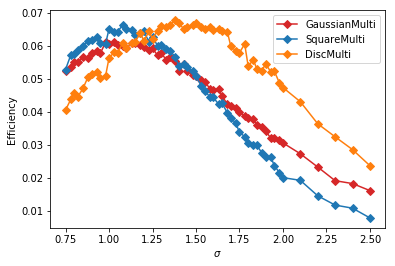

In [25]:
color = ['tab:red','tab:blue','tab:orange']
kernelset = ['Gaussian2D','Square2D','Disc2D','MirrorN1','MirrorN0.5']
label = ['GaussianMulti','SquareMulti','DiscMulti']
[plt.plot(np.append(np.round(np.arange(0.75,2.0,0.025),2),[2.0,2.1,2.2,2.3,2.4,2.5]),eff_kernel_d[5][kernelset[i]],marker='D',color=color[i],label=label[i]) for i in range(3)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('d_dimensional_eff_d_5.eps', format='eps', dpi=1000)
plt.show()

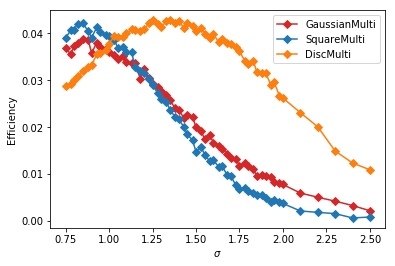

In [26]:
color = ['tab:red','tab:blue','tab:orange']
kernelset = ['Gaussian2D','Square2D','Disc2D','Two1DGaussian','Two1DUniform']
label = ['GaussianMulti','SquareMulti','DiscMulti']
[plt.plot(np.append(np.round(np.arange(0.75,2.0,0.025),2),[2.0,2.1,2.2,2.3,2.4,2.5]),eff_kernel_d[8][kernelset[i]],marker='D',color=color[i],label=label[i]) for i in range(3)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('d_dimensional_eff_d_8.eps', format='eps', dpi=1000)
plt.show()

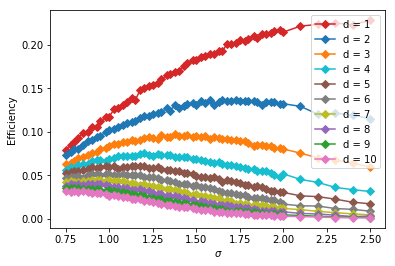

In [73]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green','tab:pink']
[plt.plot(sigmaset,eff_kernel_d[i]['Gaussian2D'],marker='D',color=color[i-1],label='d = '+ str(i)) for i in range(1,11)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('d_dimensional_eff_gaussian_kernel.eps', format='eps', dpi=1000)
plt.show()

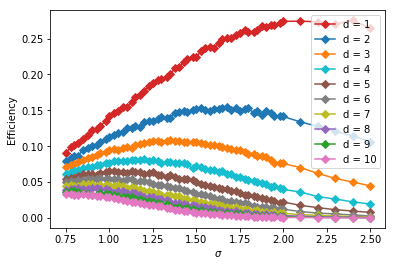

In [72]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green','tab:pink']
[plt.plot(sigmaset,eff_kernel_d[i]['Square2D'],marker='D',color=color[i-1],label='d = '+ str(i)) for i in range(1,11)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('d_dimensional_eff_square_kernel.eps', format='eps', dpi=1000)
plt.show()